# Plot ```z_log_var``` and ```z_mean``` norms

For now we have just ignored the ```z_log_var``` produced by the encoder and focused on the information given by ```z_mean```. It is of interest to look at what information could variance give us on the normal/anormal character of a digit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.classification import AUCCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.visualisation.tSNE import plot_tSNE

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tue Jul 14 09:29:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)
print(y_test[:5], y_test0[:5])

11493376/11490434 [==============================] - 0s 0us/step
(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)
[7 2 1 0 4] [1 1 1 0 1]


In [4]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/UAD/MNIST/saved_models/")
vae = tf.keras.models.load_model("vae_16_3")

In [ ]:
predictions = vae.predict(x_test)

Text(0.5, 1.0, "Model's prediction")

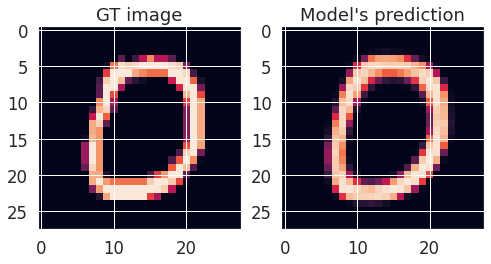

In [7]:
idx = 10
fig, axis = plt.subplots(1, 2, figsize=(8, 6))
axis[0].imshow(np.squeeze(x_test[idx], -1))
axis[0].set_title("GT image")
axis[1].imshow(np.squeeze(predictions[idx], -1))
axis[1].set_title("Model's prediction")

t-SNE inputs shape: (10000, 128)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 8)
t-SNE inputs shape: (10000, 128)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 8)


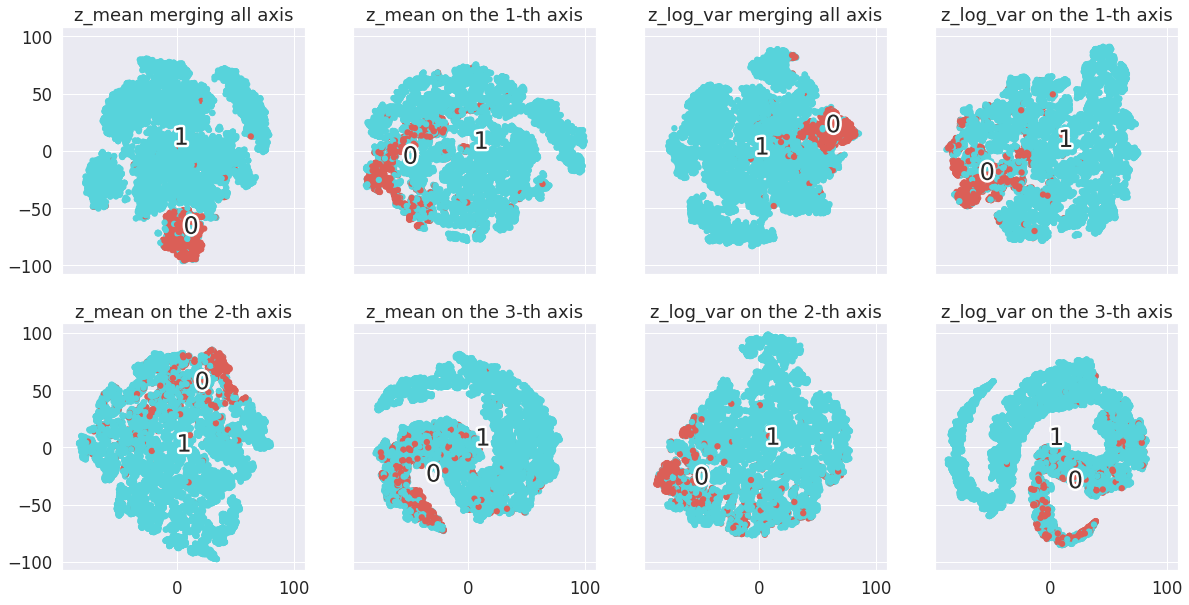

In [11]:
z_means, z_log_vars, _ = vae.encoder.predict(x_test)

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey="all", sharex="all")

a1 = np.array([axes[0][0], axes[0][1], axes[1][0], axes[1][1]])
a2 = np.array([axes[0][2], axes[0][3], axes[1][2], axes[1][3]])

# z_means
for i, ax in enumerate(a1.flatten()):
  plot_tSNE(z_means, y_test0, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("z_mean merging all axis")
  else:
    ax.set_title(f"z_mean on the {i}-th axis")

# z_log_vars
for i, ax in enumerate(a2.flatten()):
  plot_tSNE(z_log_vars, y_test0, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("z_log_var merging all axis")
  else:
    ax.set_title(f"z_log_var on the {i}-th axis")

As usual, the decomposition along each axis doesn't separate the normal/anormal class as well as the merging projection. We see that the normal class is still pretty well segregated using the ```z_log_var``` variable as well. We could imagine to use both information to predict the class of an example.

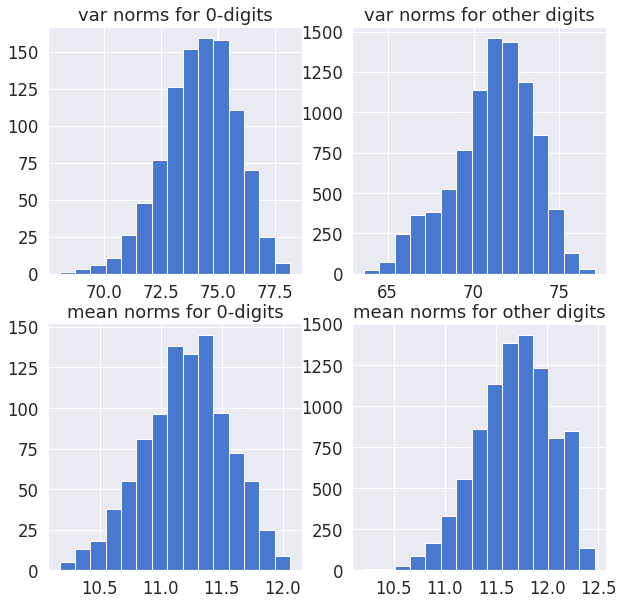

In [17]:
var_norms_0, var_norms_other = [], []
for var, lab in zip(z_log_vars, y_test0):
  vector = tf.norm(var, ord="fro", axis=(1, 2))
  if lab == 0:
    var_norms_0.append(tf.norm(vector, ord="euclidean", axis=-1))
  else:
    var_norms_other.append(tf.norm(vector, ord="euclidean", axis=-1))
var_norms_0 = np.array(var_norms_0)
var_norms_other = np.array(var_norms_other)

mean_norms_0, mean_norms_other = [], []
for mean, lab in zip(z_means, y_test0):
  vector = tf.norm(mean, ord="fro", axis=(1, 2))
  if lab == 0:
    mean_norms_0.append(tf.norm(vector, ord="euclidean", axis=-1))
  else:
    mean_norms_other.append(tf.norm(vector, ord="euclidean", axis=-1))
mean_norms_0 = np.array(mean_norms_0)
mean_norms_other = np.array(mean_norms_other)

fir, axis = plt.subplots(2, 2, figsize=(10, 10))
for ax, n, title in zip(axis.flatten(), [var_norms_0, var_norms_other, mean_norms_0, mean_norms_other], 
                        ["var norms for 0-digits", "var norms for other digits", "mean norms for 0-digits", "mean norms for other digits"]):
  ax.hist(n, bins=15)
  ax.set_title(title)


We see that the values of the norms of latent mean and latent variance vectors have similar distributions with similar values. Thus it will not be possible, for this model (trained with the specific loss function), to discriminate normal class and anormal class using the two norms.